# Building Spam Filter With Naive Bayes

The dataset that I am going to use is put together by Tiago A. Almeida and José María Gómez Hidalgo. 

Description from their <a href="http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/#composition" >site</a>:

    "The SMS Spam Collection v.1 is a public set of SMS labeled messages that have been collected for mobile phone spam research. It has one collection composed by 5,574 English, real and non-enconded messages, tagged according being legitimate (ham) or spam."
    




To classify messages as spam or non-spam the computer:

     - Learns how humans classify messages.
     - Uses that human knowledge to estimate probabilities for new messages — probabilities for spam and non-spam.
     - Classifies a new message based on these probability values — if the probability for spam is greater, then it classifies the message as spam. Otherwise, it classifies it as non-spam (if the two probability values are equal, then we may need a human to classify the message).
     
     
So our first task is to "teach" the computer how to classify messages. To do that, we'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by humans.

# Explore The Data

In [1]:
import pandas as pd
data = pd.read_csv('SMSSpamCollection', sep='\t', header=None,names=['Label', 'SMS'])

In [2]:
data

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
data['Label'].value_counts()

ham     4825
spam     747
Name: Label, dtype: int64

In [4]:
percentage = 747/5572*100
print ("spam message percentage is: {:0.01f}%".format(percentage))

spam message percentage is: 13.4%


we read in the dataset and saw that about 87% of the messages are ham ("ham" means non-spam), and the remaining 13% are spam

# Training and Test Set

To test the spam filter, we're first going to split our dataset into two categories:

    - A training set, which we'll use to "train" the computer how to classify messages.
    - A test set, which we'll use to test how good the spam filter is with classifying new messages.
    
We're going to keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). The dataset has 5,572 messages, which means that:

    - The training set will have 4,458 messages (about 80% of the dataset).
    - The test set will have 1,114 messages (about 20% of the dataset).
    
For this project, our goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

In [5]:
#randomize dataset, with random state 1 so that it's reproducible

datar = data.sample(frac=1, random_state=1)

In [6]:
# give 80% of dataset to training and 20% to testing
training = datar[0:4457]
training.reset_index(inplace=True)
testing = datar[4457:]
testing.reset_index(inplace=True)

check if percentages between spam and non spam remain same

In [7]:
perc1 = training['Label'].value_counts()[1]/4457*100
print ("spam message percentage in training dataset is: {:0.01f}%".format(perc1))

spam message percentage in training dataset is: 13.5%


In [8]:
perc2 = testing['Label'].value_counts()[1]/1114*100
print ("spam message percentage in training dataset is: {:0.01f}%".format(perc2))

spam message percentage in training dataset is: 13.2%


The results look good! We'll now move on to cleaning the dataset

# Cleaning the Dataset

removing the punctuation and bringing all the words to lower case

In [9]:
#remove punctuation and make all letters lowercase
training['SMS'] = training['SMS'].str.replace('\W', " ")
training['SMS'] = training['SMS'].str.lower()

<ipython-input-9-34b8a1434d71>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['SMS'] = training['SMS'].str.replace('\W', " ")
<ipython-input-9-34b8a1434d71>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['SMS'] = training['SMS'].str.lower()


# Create a Vocabulary

vocabulary for the messages in the training set

In [10]:
training['SMS'] = training['SMS'].str.split()
voc = []
for i in training['SMS']:
    for j in i:
        voc.append(j)
print (len(voc))     

#transform list to set to remove duplicates and then back to list
voc = set(voc)
voc = list(voc)
print (len(voc)) 

72423
7782


<ipython-input-10-f00524328f0a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['SMS'] = training['SMS'].str.split()


In [11]:
voc[:4]

['don', 'messy', 'over', 'delay']

# Creating DataFrame

We're now going to use the vocabulary we just created to make the data transformation we want.

In [12]:
word_counts_per_sms = {unique_word: [0] * len(training['SMS']) for unique_word in voc}

for index, sms in enumerate(training['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [13]:
print(list(word_counts_per_sms.values())[0:1])

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [14]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,don,messy,over,delay,clothes,rpl,bahamas,shinco,victors,closingdate04,...,missy,kills,dormitory,event,mudyadhu,thurs,ish,green,cherish,em
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
training_clean = pd.concat([training, word_counts], axis = 1)
training_clean.head()

,index,Label,SMS,don,messy,over,delay,clothes,rpl,bahamas,...,missy,kills,dormitory,event,mudyadhu,thurs,ish,green,cherish,em
0,1078,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4028,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,958,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4642,ham,[havent],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4674,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Calculating Constants

let's first calculate:

    1. P(Spam) and P(Ham) - Probability of Spam and Non spam messages
    2. NSpam, NHam, NVocabulary

    - NSpam is equal to the number of words in all the spam messages
    - NHam is equal to the number of words in all the non-spam messages

We'll also use Laplace smoothing and set  α = 1


The Naive Bayes algorithm will need to answer these two probability questions to be able to classify new messages:


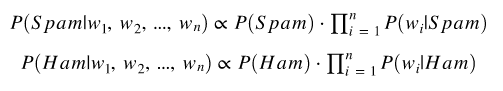

Also, to calculate P(wi|Spam) and P(wi|Ham) inside the formulas above, we'll need to use these equations:

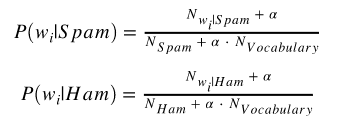

In [16]:
total = training_clean.shape[0]

# Isolating spam and ham messages first
ham = training_clean[training_clean['Label'] == 'ham'].shape[0]
spam  = training_clean[training_clean['Label'] == 'spam'].shape[0]

#calculating probabilities
P_Spam = spam/total
P_Ham = ham/total

print (P_Spam, P_Ham)

0.13461969934933812 0.8653803006506618


In [17]:
N_Voc = len(voc)
print(N_Voc)

7782


In [18]:
N_Spam = 0
N_Ham = 0

# N_Ham and N_Spam
for i in training_clean.index:
    if training_clean['Label'][i] == 'spam':
        N_Spam += len(training_clean['SMS'][i])
    elif training_clean['Label'][i] == 'ham':
        N_Ham += len(training_clean['SMS'][i])

# Laplace smoothing
alpha = 1

print (N_Spam, N_Ham)

15190 57233


# Calculating Parameters

Now that we have the constant terms calculated above, we can move on with calculating the parameters $P(w_i|Spam)$ and $P(w_i|Ham)$. Each parameter will thus be a conditional probability value associated with each word in the vocabulary.

The parameters are calculated using the formulas

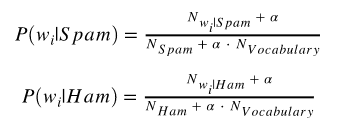

In [19]:
# create dictionaries for spam and ham including vocabulary words

dict_spam = {n: 0 for n in voc}
dict_ham = {n: 0 for n in voc}

#isolate dataframe into spam and ham
training_spam = training_clean[training_clean['Label'] == 'spam']
training_ham = training_clean[training_clean['Label'] == 'ham']

In [20]:
#fill in dictionaries with probabilities instead of 0's

for wi in voc:
    wi_count_spam = training_spam[wi].sum()
    wi_count_ham = training_ham[wi].sum()
    
    wi_p_spam = (wi_count_spam + alpha) / (N_Spam + N_Voc * alpha)
    wi_p_ham = (wi_count_ham + alpha) / (N_Ham + N_Voc * alpha)
    
    dict_spam[wi] = wi_p_spam
    dict_ham[wi] = wi_p_ham

# Classifying A New Message

Now that we have all our parameters calculated, we can start creating the spam filter. The spam filter can be understood as a function that:

Takes in as input a new message (w1, w2, ..., wn).
Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn).
Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:

    - If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
    - If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
    - If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.

In [21]:
import re

def classify(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    '''    
    This is where we calculate:

    p_spam_given_message = ?
    p_ham_given_message = ?
    ''' 
    p_spam_given_message = P_Spam
    p_ham_given_message = P_Ham
    
    for m in message: 
        if m in dict_spam:
            p_spam_given_message *= dict_spam[m]
        if m in dict_ham:
            p_ham_given_message *= dict_ham[m]       
    

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [22]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')


P(Spam|message): 1.3489598779101096e-25
P(Ham|message): 1.9380782419077522e-27
Label: Spam


In [23]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 2.4385273359614485e-25
P(Ham|message): 3.6893872875947e-21
Label: Ham


# Measuring the Spam Filter's Accuracy

The two results above look promising, but let's see how well the filter does on our test set, which has 1,114 messages.

We'll start by writing a function that returns classification labels instead of printing them

In [27]:
import re

def classify_test(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = P_Spam
    p_ham_given_message = P_Ham
    
    for m in message: 
        if m in dict_spam:
            p_spam_given_message *= dict_spam[m]
        if m in dict_ham:
            p_ham_given_message *= dict_ham[m]       

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'needs human classification'

Now that we have a function that returns labels instead of printing them, we can use it to create a new column in our test set

In [28]:
testing['predicted'] = testing['SMS'].apply(classify_test)
testing.head()

<ipython-input-28-038f8419ac86>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['predicted'] = testing['SMS'].apply(classify_test)


,index,Label,SMS,predicted
0,3482,ham,Wherre's my boytoy ? :-(,ham
1,2131,ham,Later i guess. I needa do mcat study too.,ham
2,3418,ham,But i haf enuff space got like 4 mb...,ham
3,3424,spam,Had your mobile 10 mths? Update to latest Oran...,spam
4,1538,ham,All sounds good. Fingers . Makes it difficult ...,ham


Now we can compare the predicted values with the actual values to measure how good our spam filter is with classifying new messages. To make the measurement, we'll use accuracy as a metric:

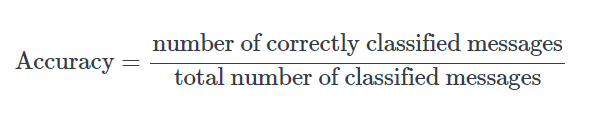

In [39]:
correct = 0
total = testing.shape[0]

for row in testing.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1
        
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)
    

Correct: 1101
Incorrect: 14
Accuracy: 0.9874439461883409



The accuracy is close to 98.74%, which is really good. Our spam filter looked at 1,114 messages that it hasn't seen in training, and classified 1,100 correctly.

### Next Steps

    - Analyze the 14 messages that were classified incorrectly and try to figure out why the algorithm classified them incorrectly
    - Make the filtering process more complex by making the algorithm sensitive to letter case